In [1]:
import warnings
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import FuncFormatter

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pmdarima
import statsmodels.tsa.api as smt

In [2]:
db = pd.read_csv('data.csv', sep=';')
db.REPORTDATE = pd.to_datetime(db.REPORTDATE, dayfirst=True)
db = db.sort_values('REPORTDATE', ascending=True)

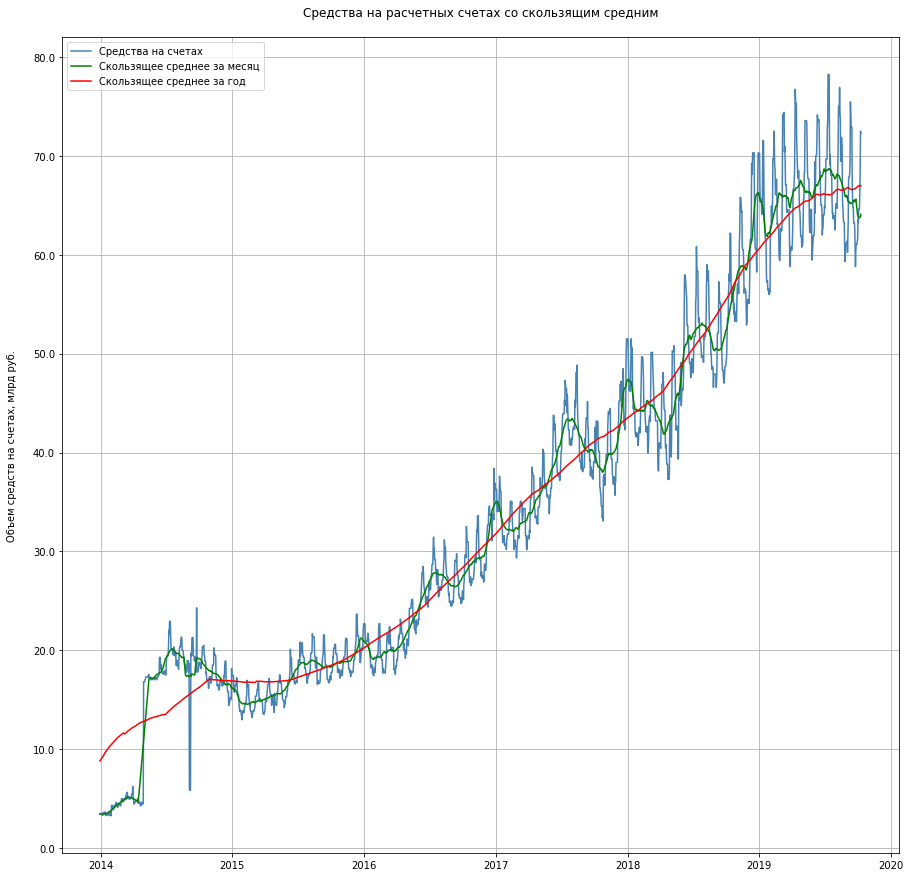

In [3]:
warnings.filterwarnings("ignore")
# Графики объема средств на счетах со скользящим средним

def plot_format(x, pos):
    return '%1.1f' % (x*1e-9)
formatter = FuncFormatter(plot_format)

ts = db.set_index('REPORTDATE').squeeze()
rolling_mean_month = ts.rolling(window=30, center=True, min_periods=15).mean()    
rolling_mean_year = ts.rolling(window=365, center=True, min_periods=182).mean()    


fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.plot(ts, label='Средства на счетах', color='steelblue')
ax.plot(rolling_mean_month, 'g', label='Скользящее среднее за месяц', color='green')
ax.plot(rolling_mean_year, 'g', label='Скользящее среднее за год', color='red')
ax.legend(loc='upper left')
ax.set_title('Средства на расчетных счетах со скользящим средним\n')
ax.set_ylabel('Объем средств на счетах, млрд руб.\n')
ax.xaxis.set_major_locator(dates.AutoDateLocator())  
ax.yaxis.set_major_formatter(formatter)
ax.grid()



In [4]:
# Возьмем для оценки временной отрезок длинной в пять лет, также исключив нерепрезентативные данные (01.06.2014 - 01.06.2019)
db = db.loc[154:1980, :].reset_index(drop=True)
ts = db.set_index('REPORTDATE').squeeze().rename('VALUE')

In [5]:
# Разделение на тренировочную и тестовую выборки

split_index = db[db.iloc[:,0]=='2019-01-01'].index[0]
ts_train = ts.head(split_index)
ts_test = ts.tail(len(ts)-split_index)

In [6]:
# Подбор параметров для модели SARIMAX

params = pmdarima.auto_arima(ts, exogenous=None, seasonal=True, stationary=False, m=30, information_criterion='aic', \
         max_order=12, max_p=3, max_q=3, max_P=3, max_Q=3, error_action='ignore')
print(f'Наилучшие параметры:\n(p, d, q): {params.order} и (P, D, Q, s): {params.seasonal_order}')

In [7]:
sarima = smt.SARIMAX(ts_train, order=(3,0,1), 
                     seasonal_order=(2,1,0,30), 
                     enforce_invertibility=False,
                     exog=None).fit()

In [8]:
# Функция для оценки модели и построения ее графиков

def model(data):
    # Расчет метрик модели на тестовой выборке
    mae = mean_absolute_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index))
    mape = mean_absolute_percentage_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index))
    rmse = mean_squared_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index), squared=False)
    # Расчет пробития на тестовой выборке
    data['penetration'] = data['forecast'].tail(len(ts)-split_index).min() - data['value'].tail(len(ts)-split_index)
    data['forecast_stable_part'] = data['forecast'].tail(len(ts)-split_index).min()
    data['real_stable_part'] = data['value'].tail(len(ts)-split_index).min()
    penetration = data.penetration[data.penetration > 0].sum()
    # Построение графиков прогноза
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    # График модели на тренировочных данных
    data[['value','forecast']].head(split_index).plot(color=['black','green'], title='Модель SARIMA', grid=True, ax=ax1)      
    ax1.set(xlabel=None)
    # График прогноза на тестовых данных
    data[['value','forecast', 'forecast_stable_part', 'real_stable_part']].tail(len(ts)-split_index).\
    plot(color=['black','red', 'orange', 'green'], title='Прогноз на тестовой выборке', grid=True, ax=ax2)
    ax2.set(xlabel=None)
    ax2.legend(loc='upper left')
    formatter = FuncFormatter(plot_format)
    ax1.yaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    plt.show()

    print(f'Значения метрик модели: MAE - {np.round(mae)} | MAPE - {np.round(mape*100)}% | RMSE - {np.round(rmse)}')
    print(f'Объем пробития прогнозной стабильной части: {penetration}')

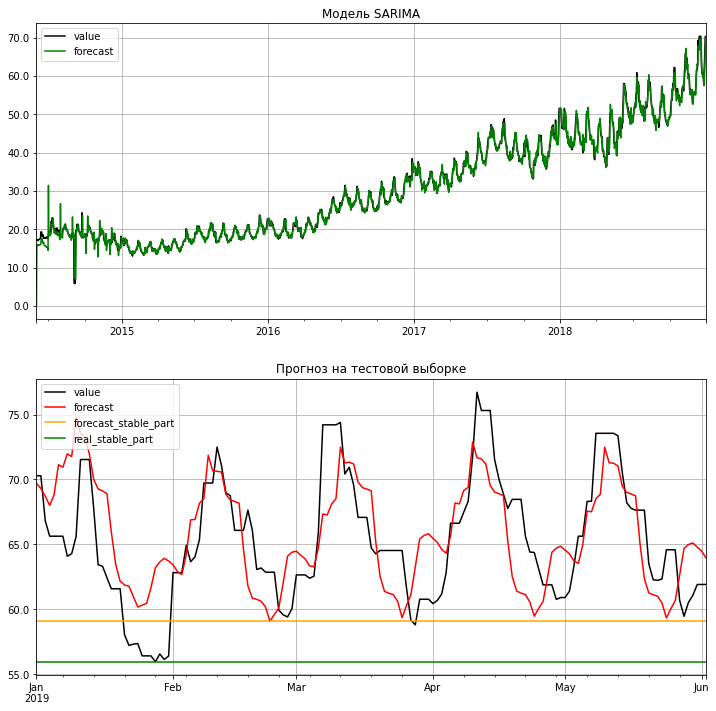

Значения метрик модели: MAE - 3058069552.0 | MAPE - 5.0% | RMSE - 3676498935.0
Объем пробития прогнозной стабильной части: 25864240858.809784


In [9]:
db_sarima_test = ts_test.to_frame(name='value')
db_sarima_test['forecast'] = sarima.predict(start=len(ts_train), end=len(ts_train)+len(ts_test)-1, exog=None)


db_sarima_train = ts_train.to_frame(name='value')
db_sarima_train['forecast'] = sarima.fittedvalues
db_sarima = db_sarima_train.append(db_sarima_test)

model(db_sarima)

In [10]:
# Создадим функцию для прогноза объема стабильной части средств с заданным горизонтом n месяцев от указанной даты

def forecast(data, start_date, horizont):
    # Выделение из ряда обучающей выборки до указанной даты
    start_date = pd.to_datetime(start_date)
    last_date = start_date + relativedelta(months=int(horizont[:-1]))
    split_index = data[data.loc[:,'REPORTDATE']==start_date].index[0]
    ts_hist = data.set_index('REPORTDATE').squeeze().rename('VALUE').head(split_index)
    db_test = pd.DataFrame(pd.date_range(start_date, last_date), columns=['REPORTDATE'])
    # Обучение модели
    sarima = smt.SARIMAX(ts_hist, order=(3,0,1), 
                         seasonal_order=(2,1,0,30), 
                         enforce_invertibility=False,
                         exog=None).fit()
    # Прогноз
    predict = sarima.predict(start=len(ts_hist), end=len(ts_hist)+len(db_test)-1, exog=None)
    # Расчет стабильной части
    stable_part = round(min(predict), 2)
    print(f'Стабильная часть средств на дату {str(start_date)[:10]} с горизонтом {int(horizont[:-1])} месяц(-а/-ев) - {stable_part}')
    # Расчет объема пробития, если указанный интервал start_data + N месяцев находится в пределах исторических данных, а также 
    # разницы между фактической и модельной стабильной частью
    if ((data.loc[len(data) - 1, 'REPORTDATE'] - last_date).days >= 0):
        db_test['forecast'] = predict.tolist()
        db_test = pd.merge(left=data, right=db_test, on='REPORTDATE', how='inner') 
        db_test['penetration'] = db_test['forecast'].min() - db_test['VALUE']
        penetration = round(db_test.penetration[db_test.penetration > 0].sum(), 2)
        print(f'Объем пробития стабильной части - {penetration}')
        delta = round(db_test['VALUE'].min() - db_test['forecast'].min(), 2)
        print(f'Разница между фактической и модельной стабильной частью - {delta if delta > 0 else 0}') 
    elif ((data.loc[len(data) - 1, 'REPORTDATE'] - last_date).days < 0):
        print('Объем пробития стабильной части и разница между фактической и модельной стабильной частью неизвестны.')
        print('Прогноз вне диапазона исторических данных.')

In [11]:
#Здесь вводится стартовая дата для прогноза и горизонт расчета

forecast(db, start_date='2019-02-03', horizont='12M')

KeyboardInterrupt: 

In [ ]:
#Здесь вводится стартовая дата для прогноза и горизонт расчета

forecast(db, start_date='2019-01-26', horizont='3M')

In [ ]:
#Здесь вводится стартовая дата для прогноза и горизонт расчета

forecast(db, start_date='2019-04-09', horizont='1M')